# Business Understanding

StyleSense, a growing online women's clothing retailer, struggles with missing recommendation data in customer reviews. Customers share feedback but don’t always specify if they’d recommend a product. This gap limits insights into customer satisfaction and product trends. 

By developing a predictive model, StyleSense can analyze review text, demographics, and product details to determine recommendations automatically. This will enhance decision-making, improve inventory management, and boost customer engagement. With data-driven insights, the company can refine product offerings, optimize marketing strategies, and drive sales growth while delivering a better shopping experience.

# Data Understanding

Our Dataset consists of **8 independent variables** and **1 dependent variable**.

Our target variable is the **`Recommended IND`** column. It contains binary based on wether the customer will recommend our product further or not. **`1`** indicates that the customer will recommended our product and **`0`** denotes the product will not be recommended.

**Independent Variables:**
- **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
- **Age**: Positive Integer variable of the reviewers age.
- **Title**: String variable for the title of the review.
- **Review Text**: String variable for the review body.
- **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
- **Division Name**: Categorical name of the product high level division.
- **Department Name**: Categorical name of the product department name.
- **Class Name**: Categorical name of the product class name.

**Target Variable:**
- **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

The Primary goal is to train a ML model which can predict if a person is likely to recommend the product or not based on various features but most specifically the **`Title`** and **`Review Text`**

## Installing Libraries

In [1]:
!python -m spacy download en_core_web_sm > /dev/null 2>&1
!pip install -q transformers==4.35.2 sentence-transformers==2.2.2
!pip uninstall -y torch > /dev/null 2>&1
!pip cache purge > /dev/null 2>&1
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q imblearn


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [33]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")


## Importing Libraries

In [34]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

## Loading Dataset

In [3]:
data = pd.read_csv('data/reviews.csv')

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
 8   Recommended IND          18442 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.3+ MB


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Recommended IND
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants,1
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses,1
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses,0
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits,1


## Defining Dependent and Independent Variables

In [4]:
df = data.copy()
df = df.sample(frac=1/3, random_state=27).reset_index(drop=True)
df.reset_index(drop=True,inplace=True)

X = df.drop(['Recommended IND','Clothing ID'], axis=1)
y = df['Recommended IND'].copy()

print('Labels:', y.unique())
print('Features:')
display(X.head())

Labels: [1 0]
Features:


,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name
0,36,Trendy simplicity,This shirt is a great way to rock the off the ...,0,General,Tops,Knits
1,53,Soft swing dress,I love the way this dress feels and falls. . i...,1,General Petite,Dresses,Dresses
2,60,Gorgeous,This shirt is nothing like the online pictures...,0,General,Tops,Knits
3,66,"Beautiful, but too big.","Based on reviews, i got the medium pink size: ...",1,General,Tops,Blouses
4,38,Great fit & so cute!,Really really like this dress. expected it to ...,0,General,Dresses,Dresses


## Data Exploration

In [22]:
blue = '#72A6D2'
pink = '#D46C8A'

### Overall Product Recommendability

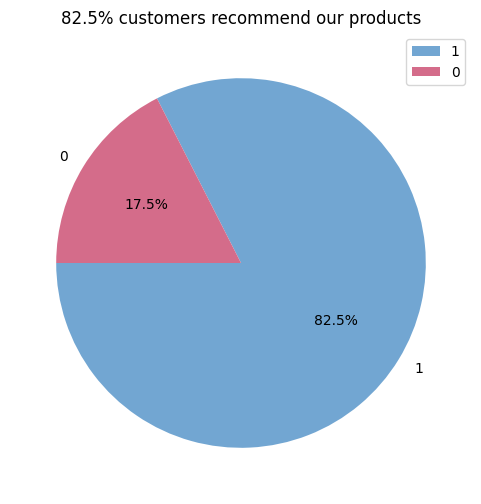

In [23]:
recommend_counts = df['Recommended IND'].value_counts()

labels = recommend_counts.index

plt.figure(figsize=(6, 6))
plt.pie(recommend_counts, labels=labels, autopct='%1.1f%%', colors=[blue, pink], startangle=180)

plt.title(f"{df['Recommended IND'].mean().round(3)*100}% customers recommend our products")
plt.legend()

plt.show()

The pie chart indicates that a significant majority of customers 82.5% recommend our products, while only 17.5% do not.

### Product Class

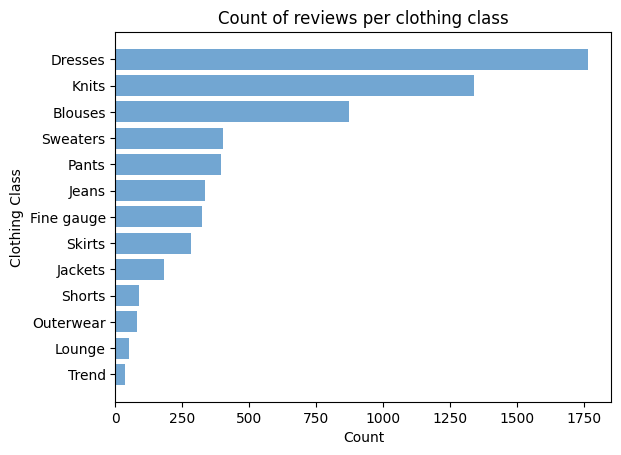

In [24]:
class_counts = df['Class Name'].value_counts().sort_values(ascending=True)

plt.barh(class_counts.index, class_counts.values, color = blue)

plt.xlabel('Count')
plt.ylabel('Clothing Class')
plt.title('Count of reviews per clothing class')

plt.show()

This bar chart displays the number of reviews per clothing class, with `Dresses` receiving the highest number of reviews, followed by `Knits` and `Blouses`. The least-reviewed categories include `Lounge` and `Trend`

### Recommendability By Clothing CLass

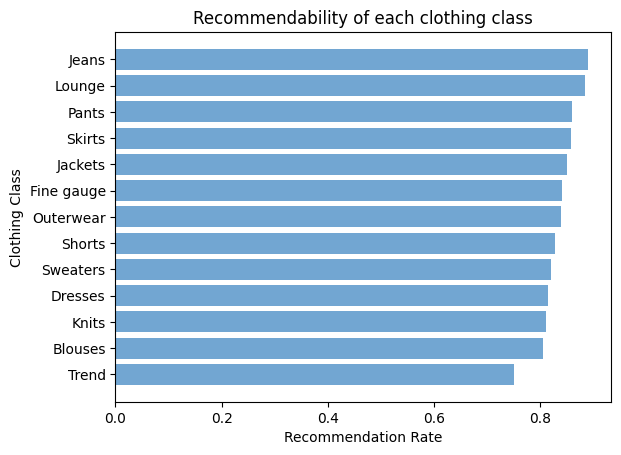

In [31]:
recommendation_by_class = (
    df.groupby('Class Name')
      .agg(recommended=('Recommended IND', 'mean'))
      .sort_values(by='recommended', ascending=True)
      .head(20)
)

plt.barh(recommendation_by_class.index, recommendation_by_class['recommended'], color = blue)

plt.xlabel('Recommendation Rate')
plt.ylabel('Clothing Class')
plt.title('Recommendability of each clothing class')
plt.show()

The bar chart illustrates the recommendability of different clothing classes based on customer feedback. "Jeans" and "Lounge" have the highest recommendation rates, indicating strong customer preference. Most clothing categories have relatively high recommendation rates, with "Trend" receiving the lowest, suggesting it is less favored compared to the other categories. This distribution highlights which clothing classes are more likely to generate positive customer recommendations.

### Recommendability By Department

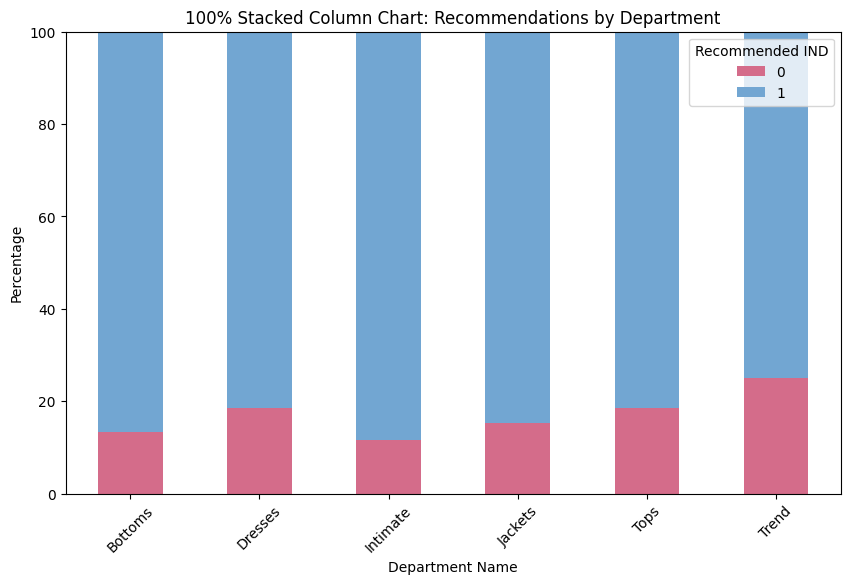

In [26]:
stacked_data = df.groupby(['Department Name', 'Recommended IND']).size().unstack()
stacked_data = stacked_data.div(stacked_data.sum(axis=1), axis=0) * 100

stacked_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=[pink, blue])

plt.xlabel('Department Name')
plt.ylabel('Percentage')
plt.title('100% Stacked Column Chart: Recommendations by Department')
plt.legend(title='Recommended IND')
plt.xticks(rotation=45)
plt.ylim(0, 100)

plt.show()

The stacked column chart displays the percentage of recommendations across different departments. Across all departments, a higher proportion of customers tend to recommend the products (indicated by the blue section), while a smaller percentage does not (indicated by the pink section). The `Trend` department has the highest proportion of non-recommendations compared to others, while `Intimate` and `Bottoms` show the lowest proportion of non-recommendations. Overall, the recommendation rate remains consistently high across all departments.

### Age Distribution Of Customers

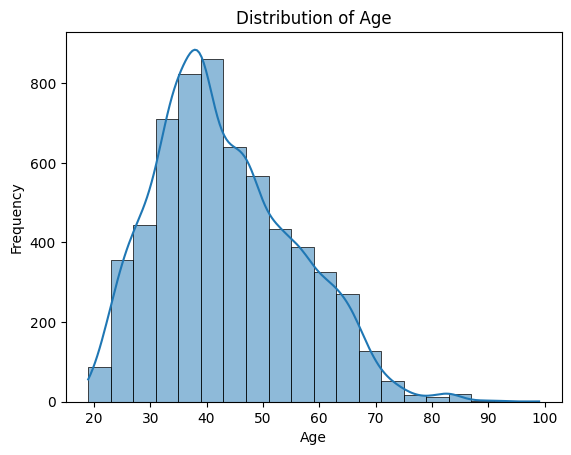

In [27]:
sns.histplot(df['Age'], bins=20, kde=True, linewidth = 0.5)

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')

plt.show()

The age distribution is right-skewed, with the highest frequency occurring around age 40. There is a sharp increase leading up to this peak, followed by a steep decline around age 45. Beyond this point, the distribution continues to decrease but at a more gradual pace. The presence of a long tail extending into older age groups suggests a smaller but persistent number of older individuals in the dataset.

### Age Distribution by Recommendation

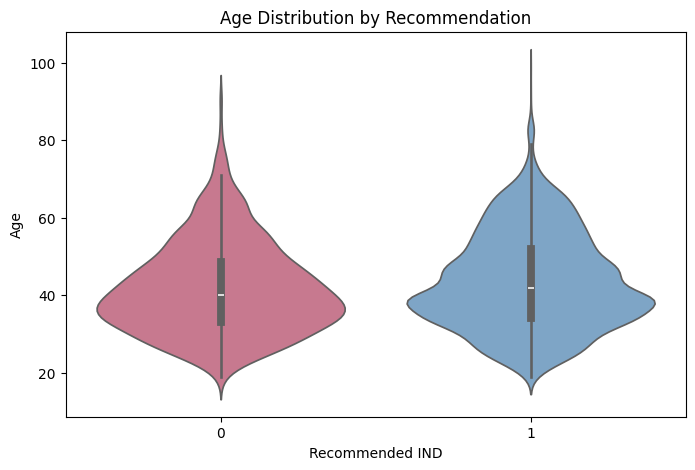

In [35]:
plt.figure(figsize=(8, 5))
sns.violinplot(x='Recommended IND', y='Age', data=df, palette=[pink,blue])

plt.xlabel('Recommended IND')
plt.ylabel('Age')
plt.title('Age Distribution by Recommendation')

plt.show()

Observing the width of the plots, we can see that older customers are more likely to recommend our products. As age increases, the density of `Recommend IND = 0` steadily declines, indicating fewer non-recommendations. In contrast, `Recommend IND = 1` shows a fluctuating pattern with noticeable peaks, particularly around age 60, where the proportion of recommendations remains significantly higher compared to `Recommend IND = 0`.

# Data Prepration

## Conducting a Train-Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    shuffle=True,
    random_state=27,
)

## Catagorizing Features for Preprocessing

In [14]:
# Catagorising Features
num_features = list(X.select_dtypes(include='number').columns)
cat_features = list(X.select_dtypes(include='object').columns.drop(['Review Text', 'Title']))
text_features = ['Title', 'Review Text']

## Defining Functions for Custom Transformations

In [36]:
# Creating a function for lemmatization
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    if pd.isna(text):
        return ""
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

# Creating a BERT Custom Transformer
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

class BERTPCATransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model, n_components=0.85):
        self.model = model
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)

    def fit(self, X, y=None):
        embeddings = np.array(self.model.encode(X.tolist()))
        self.pca.fit(embeddings)
        return self

    def transform(self, X):
        embeddings = np.array(self.model.encode(X.tolist()))
        return self.pca.transform(embeddings)


## Creating Feature Engineering Pipeline

In [16]:
# Define numerical and categorical transformers
num_transformer = Pipeline([('scaler', MinMaxScaler())])
cat_transformer = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))])

# Apply BERT embeddings
bert_transformer = ColumnTransformer([
    ('title_bert', BERTPCATransformer(model=bert_model), 'Title'),
    ('review_bert', BERTPCATransformer(model=bert_model), 'Review Text')
])

# Apply TF-IDF with lemmatization
tfidf_transformer = ColumnTransformer([
    ('title_tfidf', TfidfVectorizer(max_features=4000, preprocessor=lemmatize_text), 'Title'),
    ('review_tfidf', TfidfVectorizer(max_features=10000, preprocessor=lemmatize_text), 'Review Text')
])

# Combine text features
text_transformer = ColumnTransformer([
    ('bert', bert_transformer, ['Title', 'Review Text']),
    ('tfidf', tfidf_transformer, ['Title', 'Review Text'])
])

# Feature engineering pipeline
feature_engineering = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features),
    ('text', text_transformer, ['Title', 'Review Text'])
])

# Transform X using feature engineering
feature_engineering_pipeline = Pipeline([
    ('feature_engineering', feature_engineering)
])

# Apply SMOTE separately
smote = SMOTE(sampling_strategy=0.5, random_state=27)
X_transformed = feature_engineering_pipeline.fit_transform(X_train)
X_resampled, y_resampled = smote.fit_resample(X_transformed, y_train)


# Modeling

## Creating Model Pipline 

In [17]:
model_pipeline = Pipeline([
    ('log_reg', LogisticRegression(class_weight='balanced', random_state=27))
])

## Fine Tuning Model With Grid Search CV

In [18]:
# Define hyperparameters to tune
param_grid = {
    'log_reg__C': [10, 100],
    'log_reg__solver': ['liblinear', 'lbfgs', 'saga'],
    'log_reg__max_iter': [500, 1000],
}

# Grid search
grid_search = GridSearchCV(model_pipeline,
                           param_grid, cv=3, 
                           scoring='accuracy', 
                           n_jobs=-1, 
                           verbose=3)
grid_search.fit(X_resampled, y_resampled)

# Best model
best_model = grid_search.best_estimator_

# Best parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END log_reg__C=10, log_reg__max_iter=500, log_reg__solver=liblinear;, score=0.925 total time=   0.5s
[CV 2/3] END log_reg__C=10, log_reg__max_iter=500, log_reg__solver=liblinear;, score=0.935 total time=   0.4s
[CV 3/3] END log_reg__C=10, log_reg__max_iter=500, log_reg__solver=liblinear;, score=0.953 total time=   0.4s
[CV 1/3] END log_reg__C=10, log_reg__max_iter=500, log_reg__solver=lbfgs;, score=0.925 total time=   0.3s
[CV 2/3] END log_reg__C=10, log_reg__max_iter=500, log_reg__solver=lbfgs;, score=0.936 total time=   0.2s
[CV 3/3] END log_reg__C=10, log_reg__max_iter=500, log_reg__solver=lbfgs;, score=0.953 total time=   0.3s
[CV 1/3] END log_reg__C=10, log_reg__max_iter=500, log_reg__solver=saga;, score=0.925 total time=   2.3s
[CV 2/3] END log_reg__C=10, log_reg__max_iter=500, log_reg__solver=saga;, score=0.935 total time=   2.4s
[CV 3/3] END log_reg__C=10, log_reg__max_iter=500, log_reg__solver=saga;, score=0

## Using Best Parameters To Create Final Pipeline

In [19]:
# Retrieve best parameters from grid search
best_params = grid_search.best_params_

# Final pipeline
best_model_pipeline = ImbPipeline([
    ('feature_engineering', feature_engineering),
    ('smote', SMOTE(sampling_strategy=0.5, random_state=27)),
    ('log_reg', LogisticRegression(
        C=best_params['log_reg__C'], 
        max_iter=best_params['log_reg__max_iter'], 
        solver=best_params['log_reg__solver'],
        class_weight='balanced',
        random_state=27
    ))
])


In [20]:
joblib.dump(best_model_pipeline, 'models/best_model_pipeline.pkl')

['models/best_model_pipeline.pkl']

# Evaluation

## Training & Testing Our Final Pipeline

In [21]:
# Fit the final pipeline
best_model_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = best_model_pipeline.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.74      0.72       105
           1       0.95      0.93      0.94       510

    accuracy                           0.90       615
   macro avg       0.82      0.84      0.83       615
weighted avg       0.90      0.90      0.90       615

